# YOLO v1

### The YOLOv1 model for object detection

YOLOv1 paper: https://arxiv.org/pdf/1506.02640

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

The goal of YOLO is to add bounding boxes around the objects and classify them.

### The input and the output

The system works as follows:
- Divides the input image into an SxS grid. In the paper they use S=7
- If the center of an object falls into a grid cell, then THAT grid cell is the responsible for detecting that object
- Each cell predicts B bounding boxes (in the paper they use B=2) and confidence scores for those boxes. 
    - *Intersection Over Union* is a metric that quantifies how good a bounding box is. First you calculate the area of the intersection of the two boxes, then the area of the union, and the metric is just the area_intersection/area_union. This is between 0 and 1. We want this metic to be close to one.
    - The confidence score is defined as prob(object) * IOU(true bbox, pred bbox). If there is no object in the cell, then the confidence score should be zero. Otherwise, the confidence score should be equal to the intersection over union (IOU) between the predicted box and the ground truth.

Each bounding box consists on 5 predictions: x, y, w, h and confidence. The (x,y) represent the center of the box relative to the bounds of the grid cell (they are between 0 and 1). The w, h width and height,are predicted relative to the whole image. Finally, the confidence prediction respresents the IOU between the predicted box and the ground truth box.

Each cel also predicts C conditional class probabilites P(class_i | object): given that there is and object in the cell, the probability that it is of the class i. It is important to note thgat they only predcit a set of class probabilites, so only one object can be detected within a cell.

In the paper they use PASCAL VOC as a training set, this dataset has 20 labelled classes. Also, they use 2 bounding boxes, and split the images in a 7x7 grid, so B=2, S=7 and C=20. For each cell, the predicted label will be a vector of 5*B + C elements. So in total 30. Therefore the predicition will be a tensor of 7x7x30.


### The dataset

We use the Pascal VOC 2008 dataset, you can download it from here: http://host.robots.ox.ac.uk/pascal/VOC/voc2008/index.html (Currently I don't have much space, but it would be better to download the 2012 one)

Ther are 20 classes, each JPEG image has associated a XML file with information such as the filename of the image, the dimensions of the image and for each object, the bounding box and the coordinates of the top left and bottom right corners.

The YOLO model expects the bounding boxes being parametrized with the center point and with the width and height of it, so we need a function to convert the corner coordinates to the YOLO ones

In [ ]:
import cv2
import xml.etree.cElementTree as etree
import matplotlib.pyplot as plt
import numpy as np
import os

# We will convert an annotation xml file to a csv to handle it better
# We will create a file, where each bounding box will be transalted to a line. The line will have tab separated elements. 
#       The first will be the class index
#       The second the and third the center point relative to the whole image. Later it will be converted to the center point relative to the cell
#       The fourth and the fifht the width and the height relative to the whole image
def convert_annotation_file(xml_file, image_size=448):
    pass    




In [67]:
import cv2
import xml.etree.cElementTree as etree
import matplotlib.pyplot as plt
import numpy as np
import os


def parse_xml_file(filename, images_folder, annotations_folder, image_size=448):

    # Parse the xml file
    tree = etree.parse(os.path.join(annotations_folder, filename))

    # Get the image name
    image_name = tree.find('.//filename').text
    # print(f"{image_name=}")

    # Get the width and height of the image
    width, height = float(tree.find('.//size//width').text), float(tree.find('.//size//height').text)
    coord_names = ['xmin', 'ymin', 'xmax', 'ymax'] 
    wf, hf = width/image_size, height/image_size

    objects = tree.findall('.//object')
    bboxes = []
    for object in objects:
        object_name = object.find('.//name').text

        bbox = np.array([ float(object.find(f'.//bndbox//{coord_name}').text) for coord_name in coord_names])
        # bbox = np.array([ bbox[0] / wf, bbox[1]/hf, bbox[2]/wf - bbox[0]/wf, bbox[3]/hf - bbox[1]/hf])
        bbox[:2] /= wf
        bbox[2:] /= hf

        bboxes.append((bbox, object_name)) 

        # print(f"{object_name=}\n{bbox=}")

    # returns the bboxes as (top left coords, w, h)
    return bboxes, os.path.join(images_folder, image_name)

def draw_bboxes(image_path, bboxes, image_size=448):    
    # requires the bboxes as (topleft coords, w, h). bboxes includes also the object name

    # Read the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size)) # very raw, because it distorts everything, but for now, let's try it
    
    for bbox, object_name in bboxes:
        x,y,w,h = bbox.astype(int)
        # cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cv2.rectangle(img, (x, y), (w, h), (0, 0, 255), 2)
        
        # Finds space required by the text so that we can put a background with that amount of width.
        (wl, hl), _ = cv2.getTextSize(object_name, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img, (x, y), (x + wl, y + hl*2), (0,0,255,), -1)
        cv2.putText(img, object_name, (x, y+ int(1.5 * hl)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    # cv2.imshow('img', img)
    # cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()


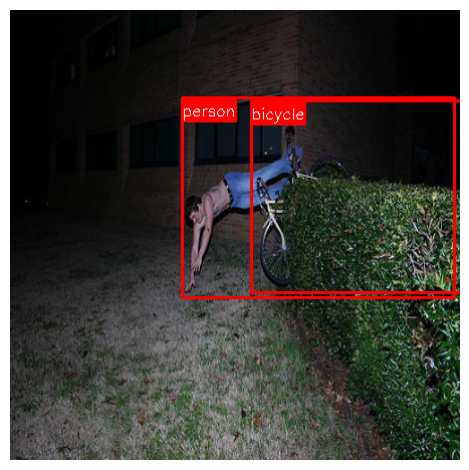

In [68]:
images_folder = "./data/VOC2008/JPEGImages"
annotations_folder = "./data/VOC2008/Annotations"
filename = "2008_008695.xml"
image_size = 448

bboxes, image_path = parse_xml_file(filename=filename, images_folder=images_folder, annotations_folder=annotations_folder, image_size=image_size)
draw_bboxes(image_path=image_path, bboxes=bboxes)

In [ ]:
def corners_to_yolo(bboxes, image_size, S):
    


# The model
Figure 3 of the paper

In [33]:
# The architecture is a sequence of convolutional layers. To avoid writting much, we specify the architecuter in a list form (for now).
# The input of the net is a (448, 448, 3) image
# For a conv layer: output_size = (input_size - kernel_size + 2*padding)/stride + 1

architecture_YOLOv1 = [
    # (out_channels, kernel_size, stride, padding)
    (64, 7, 2, 3), # (3, 448, 448) -> (64, 224, 224) the padding of 3 to ensure that it halfs the input
    "MaxPool", # (64, 224, 224) -> (64, 112, 112)

    (192, 3, 1, 1), # (64, 112, 112) -> (192, 112, 112)
    "MaxPool", # (192, 112, 112) -> (192, 56, 56)

    (128, 1, 1, 0), # (192, 56, 56) -> (128, 56, 56)
    (256, 3, 1, 1), # (128, 56, 56) -> (256, 56, 56)
    (256, 1, 1, 0), # (256, 56, 56) -> (256, 56, 56
    (512, 3, 1, 1), # (256, 56, 56) -> (512, 56, 56)
    "MaxPool",  # (512, 56, 56) -> (512, 28, 28)

    [ (256, 1, 1, 0), (512, 3, 1, 1), 4], # (512, 28, 28) -> (256, 28, 28)
    (512, 1, 1, 0), # (512, 28, 28) -> (512, 56, 56)
    (1024, 3, 1, 1), # (512, 28, 28) -> (1024, 56, 56)
    "MaxPool", # (1024, 28, 28) -> (1024 , 14, 14)

    [(512, 1, 1, 0), (1024, 3, 1, 1), 2], # (1024, 14, 14) -> (512, 14, 14)
    (1024, 3, 1, 1), # (1024, 14, 14) -> (1024, 14, 14)
    (1024, 3, 2, 1), # (1024, 14, 14) -> (1024, 7, 7) padding 1 to ensure half output
 
    (1024, 3, 1, 1),  # (1024, 7, 7) -> (1024, 7, 7)
    (1024, 3, 1, 1),  # (1024, 7, 7) -> (1024, 7, 7)
]

In [ ]:


class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels) # This is not used in the original YOLOv1 paper
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)

        return x


class YOLOv1(nn.Module):
    def __init__(self, architecture, num_cells, num_boxes, num_classes):
        super().__init__()

        self.architecture = architecture
        self.in_channels = 3
        self.hidden_dim = 4096 # As in the paper. If too much VRAM, you can reduce it
        self.S = num_cells
        self.B = num_boxes
        self.C = num_classes
        
        
        # build the convolutional network 
        self.conv_net = self._build_conv_net(self.in_channels) 
        self.last_shape = self._get_last_shape(self.in_channels)
        # create the fully connected layers
        self.fcs = self._create_fcs()


        # For the loss
        self.lambda_coord = 5 # the lambda_coord from the paper
        self.lambda_noobj = 0.5 # the lambda_noobs from the paper
        self.box_format = "center"


    @staticmethod
    def _parse_tuple(in_channels, tuple_to_parse):
        out_channels, kernel_size, stride, padding = tuple_to_parse 
        return ConvolutionalBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def _build_conv_net(self, in_channels):
        layers = []
        current_channels = in_channels
        for i in range(len(self.architecture)):
            current_layer = self.architecture[i]
            if current_layer == "MaxPool": layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            if isinstance(current_layer, tuple): 
                layers.append(self._parse_tuple(in_channels=current_channels, tuple_to_parse=current_layer))
                current_channels = current_layer[0]  # set the current_channels to the channels of the current_layer
            if isinstance(current_layer, list):
                repeat_times = current_layer[-1] # the number of times to repeat
                for _ in range(repeat_times):
                    for l in current_layer[:-1]:
                        layers.append(self._parse_tuple(in_channels=current_channels, tuple_to_parse=l))
                        current_channels = l[0]  # set the current_channels to the channels of the current_layer
        return nn.Sequential(*layers)


    def _get_last_shape(self, in_channels):
        dummy_input = torch.randn(1, in_channels, 448, 448)
        last_shape = self._build_conv_net(in_channels)(dummy_input)[0].nelement()
        return last_shape

    def _create_fcs(self):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.last_shape, self.hidden_dim),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(self.hidden_dim, self.S * self.S * (self.B * 5 + self.C)) 
        )
    

    # The forward method
    def forward(self, x):
        x = self.conv_net(x)
        x = self.fcs(x)
        x = x.reshape(x[0], self.S, self.S, self.B * 5 + self.C)
        return x


### The loss function

Eq. 3 of the paper

In [20]:
# Intersection over union. 
# We have two bbox, with coordinates (top left and bottom right corners of the bbox): (a1, b1, a2, b2) and (c1,d1,c2,d2)

# The intersection bbox with coordinates (x1, y1, x2, y2) is then:
# x1 = max(a1, c1)
# y1 = max(b1, d1) # remember that in computer vision the y axis goes down
# x2 = min(a2, c2)
# y2 = min(b2, d2)

# the area will be (x2-x1) * (y2-y1)

# In the paper the bounding boxes cordinates are relative to the cell, that is the input

def global_to_local(boxes, image_size, S):
    '''
    The format of the boxes is corner the corner
    '''

    
    return



def intersection_over_union(boxes_preds, boxes_truth, box_format="center"):
    # the shape is (N, 4) where N is the number of boxes    

    if box_format == 'center':
        box1_x1 = boxes_preds[..., 0:1] -  boxes_preds[..., 2:3]/2
        box1_y1 = boxes_preds[..., 1:2] -  boxes_preds[..., 3:4]/2
        box1_x2 = boxes_preds[..., 0:1] +  boxes_preds[..., 2:3]/2
        box1_y2 = boxes_preds[..., 3:4] +  boxes_preds[..., 3:4]/2

        box2_x1 = boxes_truth[..., 0:1] -  boxes_truth[..., 2:3]/2
        box2_y1 = boxes_truth[..., 1:2] -  boxes_truth[..., 3:4]/2
        box2_x2 = boxes_truth[..., 0:1] +  boxes_truth[..., 2:3]/2
        box2_y2 = boxes_truth[..., 3:4] +  boxes_truth[..., 3:4]/2
    
    elif box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1] # not just 0, to keep the dimensions (N, 1)
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        box2_x1 = boxes_truth[..., 0:1] 
        box2_y1 = boxes_truth[..., 1:2]
        box2_x2 = boxes_truth[..., 2:3]
        box2_y2 = boxes_truth[..., 3:4]

    # The corners of the intersection bounding box
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    area_intersection = (y2 - y1).clamp(0) * (x2 - x1).clamp(0) # clamp(0) if not intersect
    box1_area = torch.abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = torch.abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return area_intersection/(box1_area + box2_area - area_intersection + 1e-6)


In [66]:
# ---------------------------
#
# The loss
#
# --------------------------

# The output will be (c0, c1, ..., cC,      pb1, b1x, b1y, b1w, b1h,   pb2, b2x, b2y, b2w, b2h)

def compute_loss( predictions, targets, S = 7, B = 2, C = 20, lambda_coord = 5, lambda_noobj = .5, box_format="center"):
    # predictions have shape (batch, S, S, B*5 + C), targets has only one bbox, so (batch, S, S, C + 5)
    assert predictions.shape[-1] == B*5 + C
    
    # Get the best bounding box for the predictions
    ious = [] 
    for i in range(B):
        iou = intersection_over_union(predictions[..., C + i*5 + 1 : C + (i+1)*5], targets[..., C + 1:C + 5], box_format=box_format)
        ious.append(iou.unsqueeze(1))
    ious = torch.cat(ious, dim=1)
    ious_max, responsible_box = torch.max(ious, dim=1) # get for each cell, the best bbox (with the maximum area). This one will be responsible for predicting an object 
    
    exists_box = targets[..., C].unsqueeze(3) # For the target, the element C is 1 or 0, depending if there is an object or not

    # -----------------------------------
    #  Box coordinates and sizes loss
    # -----------------------------------

    # take the best bounding predicted box
    box_predictors = predictions[..., C:].reshape(*predictions.shape[:-1], B, 5)[..., 1:] # (batch, S, S, B, 4) 
    expanded_indices = responsible_box.unsqueeze(-1).expand(-1, -1, -1, -1, box_predictors.size(-1)) 
    box_predictors = torch.gather(box_predictors, 3, expanded_indices).squeeze(3)

    identity_obj_resp = exists_box # the 1^obj_ij matrix of the paper. The fact that the responsible box is in cell i is already implicit when constructing box_predictors
    box_predictors = identity_obj_resp * box_predictors 
    box_predictors[..., 2:4] = torch.sign(box_predictors[..., 2:4]) * torch.sqrt( torch.abs(box_predictors[..., 2:4] + 1e-6) ) # for the sizes part, the 1e-6 is numerical stability, the sign is for the correct value of the gradient

    box_targets = targets[..., C:].reshape(*targets.shape[:-1],5)[..., 1:]
    box_targets = exists_box * box_targets
    box_targets[..., 2:4] = torch.sign(box_targets[..., 2:4]) * torch.sqrt( torch.abs(box_targets[..., 2:4] + 1e-6) ) 

    box_loss = F.mse_loss(box_predictors.view(-1, 4), box_targets.view(-1, 4), reduction='sum') 
    print(f"box loss: {box_loss.item()}")

   # -----------------------------------
    #  Object loss
    # -----------------------------------

    # take the best bounding predicted box
    obj_predictors = predictions[..., C:].reshape(*predictions.shape[:-1], B, 5)[..., 0:1] # (batch, S, S, B, 1) 
    expanded_indices = responsible_box.unsqueeze(-1).expand(-1, -1, -1, -1, obj_predictors.size(-1)) 
    obj_predictors = torch.gather(obj_predictors, 3, expanded_indices).squeeze(3)

    identity_obj_resp = exists_box # the 1^obj_ij matrix of the paper. The fact that the responsible box is in cell i is already implicit when constructing box_predictors
    obj_predictors = identity_obj_resp * obj_predictors 

    obj_targets = targets[..., C:].reshape(*targets.shape[:-1],5)[..., 0:1]
    obj_targets = identity_obj_resp * obj_targets


    object_loss = F.mse_loss(obj_predictors.view(-1), obj_targets.view(-1), reduction='sum') 
    print(f"object loss: {object_loss.item()}") 


    # -----------------------------------
    # No Object loss
    # -----------------------------------

    # take the bounding predicted boxes
    noobj_predictors = predictions[..., C:].reshape(*predictions.shape[:-1], B, 5)[..., 0:1].squeeze(-1)# (batch, S, S, B, 1) 

    identity_noobj_resp = 1 - exists_box # the 1^noobj_i matrix of the paper.
    identity_noobj_resp = identity_noobj_resp.repeat(1,1,1,B)

    noobj_predictors = identity_noobj_resp * noobj_predictors 
    noobj_targets = targets[..., C:].reshape(*targets.shape[:-1],5)[..., 0:1]
    noobj_targets = identity_noobj_resp * noobj_targets

    noobject_loss = F.mse_loss(noobj_predictors.view(-1), noobj_targets.view(-1), reduction='sum') 
    print(f"no object loss: {noobject_loss.item()}")

    # -----------------------------------
    #  Class Loss
    # -----------------------------------

    # take the best bounding predicted box
    class_predictors = predictions[..., :C]

    identity_obj_resp = exists_box # the 1^obj_ij matrix of the paper. The fact that the responsible box is in cell i is already implicit when constructing box_predictors
    class_predictors = identity_obj_resp * class_predictors 

    class_targets = targets[..., :C]
    class_targets = identity_obj_resp * class_targets

    class_loss = F.mse_loss(class_predictors.view(-1), class_targets.view(-1), reduction='sum') 
    print(f"class loss: {class_loss.item()}")

   # -----------------------------------
    #  Total Loss
    # -----------------------------------

    loss = lambda_coord * box_loss + object_loss + lambda_noobj * noobject_loss + class_loss
    print(f"loss: {loss.item()}")

    return loss 


### The loss

In [354]:
# The output will be (c0, c1, ..., cC,      pb1, b1x, b1y, b1w, b1h,   pb2, b2x, b2y, b2w, b2h)

# for now let us do it for two boxes
S, B, C = 3, 2, 20
batch_size = 1
# torch.manual_seed(123)
predictions = torch.randint(0, 448, (batch_size, S, S, B*5 + C)).float() + torch.arange(0, B*5+C).repeat(batch_size, S, S, 1)
targets = torch.randint(0, 448, (batch_size, S, S, 1*5 + C)).float()

# Get the best bounding box for the predictions
ious = [] 
for i in range(B):
    iou = intersection_over_union(predictions[..., C + i*5 + 1 : C + (i+1)*5], targets[..., C + 1:C + 5], box_format='center')
    ious.append(iou.unsqueeze(1))
ious = torch.cat(ious, dim=1)
ious_max, responsible_box = torch.max(ious, dim=1) # get for each cell, the best bbox (with the maximum area). This one will be responsible for predicting an object 
 
exists_box = targets[..., C].unsqueeze(3) # For the target, the element C is 1 or 0, depending if there is an object or not
exists_box = torch.randint(0,2, exists_box.shape) # just for now


In [355]:
# -----------------------------------
#  Box coordinates and sizes loss
# -----------------------------------

# take the best bounding predicted box
box_predictors = predictions[..., C:].reshape(*predictions.shape[:-1], B, 5)[..., 1:] # (batch, S, S, B, 4) 
expanded_indices = responsible_box.unsqueeze(-1).expand(-1, -1, -1, -1, box_predictors.size(-1)) 
box_predictors = torch.gather(box_predictors, 3, expanded_indices).squeeze(3)

identity_obj_resp = exists_box # the 1^obj_ij matrix of the paper. The fact that the responsible box is in cell i is already implicit when constructing box_predictors
box_predictors = identity_obj_resp * box_predictors 
box_predictors[..., 2:4] = torch.sign(box_predictors[..., 2:4]) * torch.sqrt( torch.abs(box_predictors[..., 2:4] + 1e-6) ) # for the sizes part, the 1e-6 is numerical stability, the sign is for the correct value of the gradient

box_targets = targets[..., C:].reshape(*targets.shape[:-1],5)[..., 1:]
box_targets = exists_box * box_targets
box_targets[..., 2:4] = torch.sign(box_targets[..., 2:4]) * torch.sqrt( torch.abs(box_targets[..., 2:4] + 1e-6) ) 

box_loss = F.mse_loss(box_predictors.view(-1, 4), box_targets.view(-1, 4), reduction='sum') 
print(f"box loss: {box_loss.item()}")

# by doing the sum of the paper explicitly
box_predictors = predictions[..., C:].reshape(*predictions.shape[:-1], B, 5)[..., 1:] # (batch, S, S, B, 4) 
_box_predictors = torch.empty(batch_size,S,S,4)
for N in range(batch_size):
    for s1 in range(S):
        for s2 in range(S):
            index = responsible_box[N, s1, s2, 0]
            _box_predictors[N, s1, s2, :] = box_predictors[N, s1, s2, index, :]
box_predictors = _box_predictors

box_targets = targets[..., C:].reshape(*targets.shape[:-1],5)[..., 1:]


box_loss = 0
for N in range(batch_size):
    for i1 in range(S):
        for i2 in range(S):
            id_ij = exists_box[N, i1, i2, 0] # this will be 0 or 1. If exists in that cell or not 
           
            xi = id_ij * box_predictors[N, i1, i2, 0:1]
            yi = id_ij * box_predictors[N, i1, i2, 1:2]
            wi = id_ij * torch.sign(box_predictors[N, i1, i2, 2:3]) * torch.sqrt(torch.abs(box_predictors[N, i1, i2, 2:3] + 1e-6))
            hi = id_ij * torch.sign(box_predictors[N, i1, i2, 3:4]) * torch.sqrt(torch.abs(box_predictors[N, i1, i2, 3:4] + 1e-6))
            
            xihat = id_ij * box_targets[N, i1, i2, 0:1]
            yihat = id_ij * box_targets[N, i1, i2, 1:2]
            wihat = id_ij * torch.sign(box_targets[N, i1, i2, 2:3]) * torch.sqrt(torch.abs(box_targets[N, i1, i2, 2:3] + 1e-6))
            hihat = id_ij * torch.sign(box_targets[N, i1, i2, 3:4]) * torch.sqrt(torch.abs(box_targets[N, i1, i2, 3:4] + 1e-6))

            box_loss += (xi - xihat)**2 + (yi - yihat)**2 + (wi-wihat)**2 + (hi-hihat)**2     

print(f"box loss: {box_loss.item()}")



box loss: 247085.96875
box loss: 247085.96875


In [356]:
# -----------------------------------
#  Object loss
# -----------------------------------

# take the best bounding predicted box
obj_predictors = predictions[..., C:].reshape(*predictions.shape[:-1], B, 5)[..., 0:1] # (batch, S, S, B, 1) 
expanded_indices = responsible_box.unsqueeze(-1).expand(-1, -1, -1, -1, obj_predictors.size(-1)) 
obj_predictors = torch.gather(obj_predictors, 3, expanded_indices).squeeze(3)

identity_obj_resp = exists_box # the 1^obj_ij matrix of the paper. The fact that the responsible box is in cell i is already implicit when constructing box_predictors
obj_predictors = identity_obj_resp * obj_predictors 

obj_targets = targets[..., C:].reshape(*targets.shape[:-1],5)[..., 0:1]
obj_targets = identity_obj_resp * obj_targets


object_loss = F.mse_loss(obj_predictors.view(-1), obj_targets.view(-1), reduction='sum') 
print(f"object loss: {object_loss.item()}")

# by doing the sum of the paper explicitly
obj_predictors = predictions[..., C:].reshape(*predictions.shape[:-1], B, 5)[..., 0:1] # (batch, S, S, B, 1) 
_obj_predictors = torch.empty(batch_size,S,S,1)

for N in range(batch_size):
    for s1 in range(S):
        for s2 in range(S):
            index = responsible_box[N, s1, s2, 0]
            _obj_predictors[N, s1, s2, :] = obj_predictors[N, s1, s2, index, :]
obj_predictors = _obj_predictors


# target part
obj_targets = targets[..., C:].reshape(*targets.shape[:-1],5)[..., 0:1]

object_loss = 0
for N in range(batch_size):
    for i1 in range(S):
        for i2 in range(S):
            id_ij = exists_box[N, i1, i2, 0] # this will be 0 or 1. If exists in that cell or not 
            ci = id_ij * obj_predictors[N, i1, i2, 0]
            cihat = id_ij * obj_targets[N, i1, i2, 0]

            object_loss += (ci - cihat)**2 

print(f"object loss: {object_loss.item()}")



object loss: 45462.0
object loss: 45462.0


In [381]:
# -----------------------------------
# No Object loss
# -----------------------------------

# take the bounding predicted boxes
noobj_predictors = predictions[..., C:].reshape(*predictions.shape[:-1], B, 5)[..., 0:1].squeeze(-1)# (batch, S, S, B, 1) 

identity_noobj_resp = 1 - exists_box # the 1^noobj_i matrix of the paper.
identity_noobj_resp = identity_noobj_resp.repeat(1,1,1,B)

noobj_predictors = identity_noobj_resp * noobj_predictors 
noobj_targets = targets[..., C:].reshape(*targets.shape[:-1],5)[..., 0:1]
noobj_targets = identity_noobj_resp * noobj_targets

noobject_loss = F.mse_loss(noobj_predictors.view(-1), noobj_targets.view(-1), reduction='sum') 
print(f"no object loss: {noobject_loss.item()}")

# # by doing the sum of the paper explicitly
noobj_predictors = predictions[..., C:].reshape(*predictions.shape[:-1], B, 5)[..., 0:1].squeeze(-1) # (batch, S, S, B, 1) 
# target part
noobj_targets = targets[..., C:].reshape(*targets.shape[:-1],5)[..., 0:1]

noobject_loss = 0
for N in range(batch_size):
    for i1 in range(S):
        for i2 in range(S):
            for b in range(B):
                id_ij = 1 - exists_box[N, i1, i2, 0] # this will be 0 or 1. If exists in that cell or not 
                ci = id_ij * noobj_predictors[N, i1, i2, b]
                cihat = id_ij * noobj_targets[N, i1, i2, 0]

                noobject_loss += (ci - cihat)**2 

print(f"no object loss: {noobject_loss.item()}")


no object loss: 368039.0
no object loss: 368039.0


In [387]:
# -----------------------------------
#  Class Loss
# -----------------------------------

# take the best bounding predicted box
class_predictors = predictions[..., :C]

identity_obj_resp = exists_box # the 1^obj_ij matrix of the paper. The fact that the responsible box is in cell i is already implicit when constructing box_predictors
class_predictors = identity_obj_resp * class_predictors 

class_targets = targets[..., :C]
class_targets = identity_obj_resp * class_targets

class_loss = F.mse_loss(class_predictors.view(-1), class_targets.view(-1), reduction='sum') 
print(f"class loss: {class_loss.item()}")

# # by doing the sum of the paper explicitly
class_predictors = predictions[..., :C]
class_targets = targets[..., :C]

class_loss = 0
for N in range(batch_size):
    for i1 in range(S):
        for i2 in range(S):
            for c in range(C):
                id_ij = exists_box[N, i1, i2, 0] # this will be 0 or 1. If exists in that cell or not 
                ci = id_ij * class_predictors[N, i1, i2, c]
                cihat = id_ij * class_targets[N, i1, i2, c]

                class_loss += (ci - cihat)**2 

print(f"class loss: {class_loss.item()}")

class loss: 2574372.0
class loss: 2574372.0


In [390]:
# -----------------------------------
#  Total Loss
# -----------------------------------
lambda_coord = 5
lambda_noobj = 0.5

loss = lambda_coord * box_loss + object_loss + lambda_noobj * noobject_loss + class_loss
print(f"loss: {loss.item()}")

loss: 4039283.5


In [394]:
# torch.manual_seed(123)
S, B, C = 7, 2, 20
batch_size = 10

predictions = torch.randint(0, 448, (batch_size, S, S, B*5 + C)).float() + torch.arange(0, B*5+C).repeat(batch_size, S, S, 1)
targets = torch.randint(0, 448, (batch_size, S, S, 1*5 + C)).float()

loss = compute_loss(predictions=predictions, targets=targets, S=S, B=B, C=C, lambda_coord=5, lambda_noobj=0.5)
print(loss)

box loss: 1944799281152.0
object loss: 1129856892928.0
no object loss: 2243369893888.0
class loss: 22858354917376.0
loss: 34833893949440.0
tensor(3.4834e+13)


In [ ]:
S, B, C = 7, 2, 20
model = YOLOv1(architecture=architecture_YOLOv1, num_cells=S, num_boxes=B, num_classes=C)
a = model(torch.randn(1, 3, 448, 448 )) # This should be a 7 x 7 x 30 tensor
a.shape

torch.Size([1, 7, 7, 30])